# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

### 1b. Explore the data

In [5]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [3]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [6]:
#your turn
merge_df = df_offers.merge(df_transactions,how='left',on='offer_id')
merge_df.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [7]:
df_pivot = merge_df.pivot_table(values='n',index='customer_name',columns=['offer_id']).fillna(0)
df_pivot.head()

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

Smaller values of SS represent better clustering because it means that the distance between the points and the centroid is small. For larger values of SS, the points are further away, on average, from the centroid compared to a smaller SS value.

In [8]:
#convert dataframe column values to array
import numpy as np
x_cols = np.array(df_pivot)
x_cols

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [9]:
# Import KMeans
from sklearn.cluster import KMeans

ks = range(2, 10)
SS = []
for k in ks:
    # Create a KMeans instance with K clusters
    model = KMeans(n_clusters=k,random_state=42)
    
    # Fit model to samples
    model.fit(x_cols)
    
    # Append the inertia to the list of SS
    SS.append(model.inertia_)

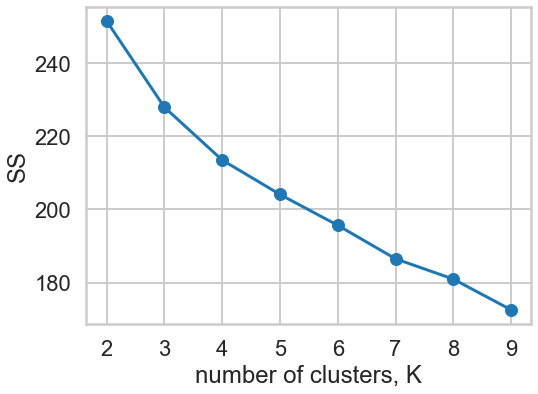

In [10]:
# Plot Ks vs SS
plt.figure(figsize=(8, 6))
plt.plot(ks, SS, '-o')
plt.xlabel('number of clusters, K')
plt.ylabel('SS')
plt.xticks(ks)
plt.tight_layout()

From the elbow plot, the best K looks to be 3 because a further increase in K does not significant reduce the SS.

In [128]:
# Create a KMeans instance with K=3 clusters
model = KMeans(n_clusters=3,random_state=42)
# Fit model to samples
model.fit(x_cols)
clusters = pd.DataFrame({"cluster":model.labels_})

In [129]:
clusters.head()

,cluster
0,0
1,2
2,1
3,0
4,0


<AxesSubplot:>

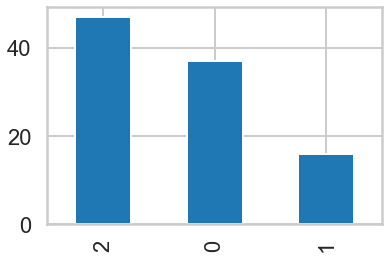

In [130]:
#bar plot of points belonging to each cluster
clusters.cluster.value_counts().sort_values(ascending=False).plot(kind='bar')

One major challenges with the elbow method is that does not always clearly delineate high and low SS. Hence, it can be difficult to pick an appropriate K value. 

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351
For n_clusters = 3 The average silhouette_score is : 0.12122715317053197
For n_clusters = 4 The average silhouette_score is : 0.11789796273719859
For n_clusters = 5 The average silhouette_score is : 0.11166629295035457
For n_clusters = 6 The average silhouette_score is : 0.10919252034158575
For n_clusters = 7 The average silhouette_score is : 0.119528131019189
For n_clusters = 8 The average silhouette_score is : 0.11772178832684693
For n_clusters = 9 The average silhouette_score is : 0.13456521258213835
For n_clusters = 10 The average silhouette_score is : 0.1350797732642118


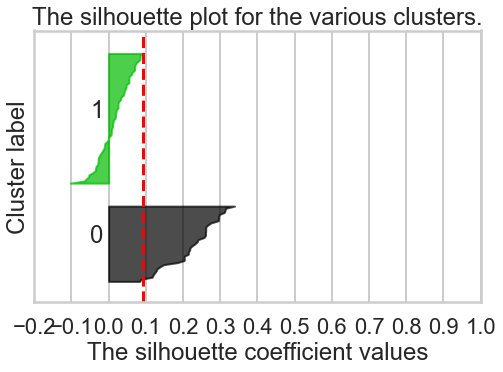

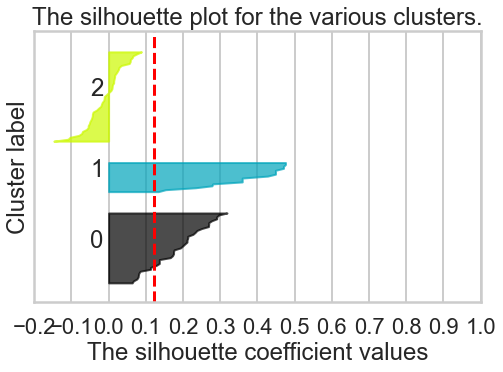

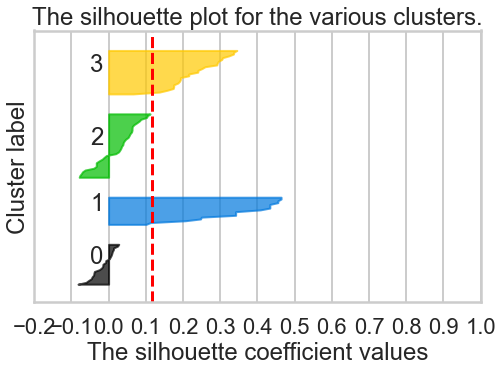

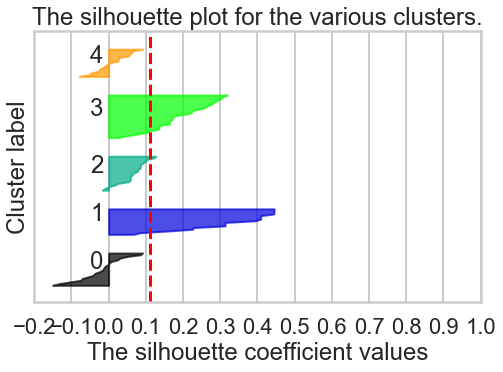

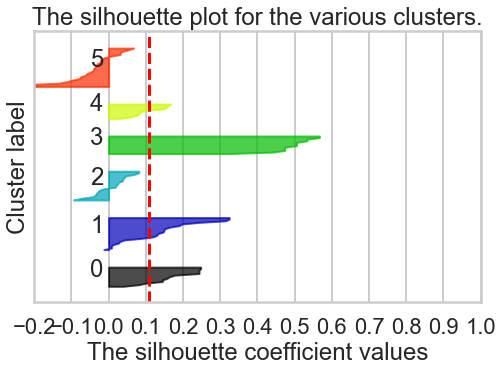

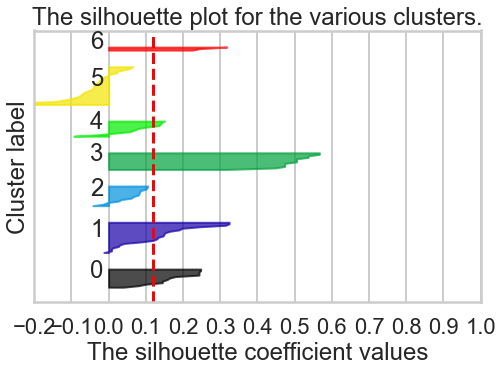

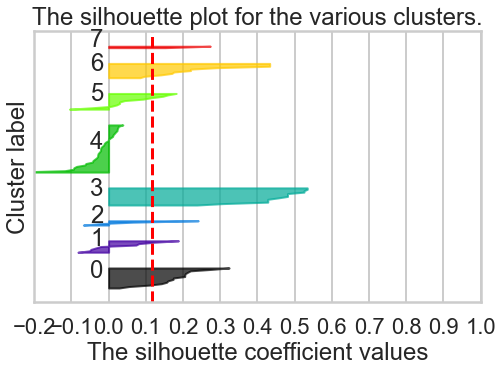

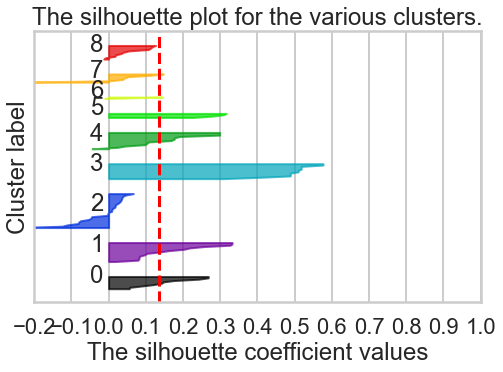

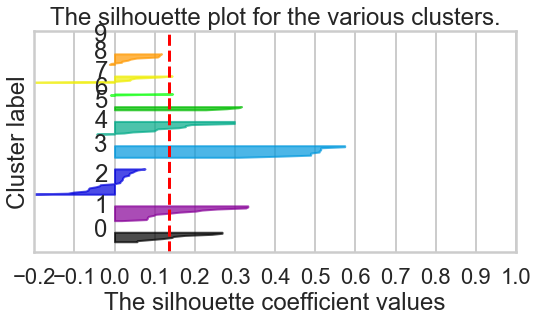

In [103]:
# import silhouette_score from sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = x_cols.copy()

#modeled after sklearn silhouette_score documentation
range_n_clusters = [k for k in range(2,11)]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([i/10.0 for i in range(-2,11)])
    
plt.tight_layout()
plt.show()

In [108]:
avg_silhouette_score = []
ks = range(2,11)

for n_clusters in ks:
    # K-means
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X)
    #compute silhouette average score
    silhouette_avg = silhouette_score(X, cluster_labels)
    avg_silhouette_score.append(silhouette_avg)

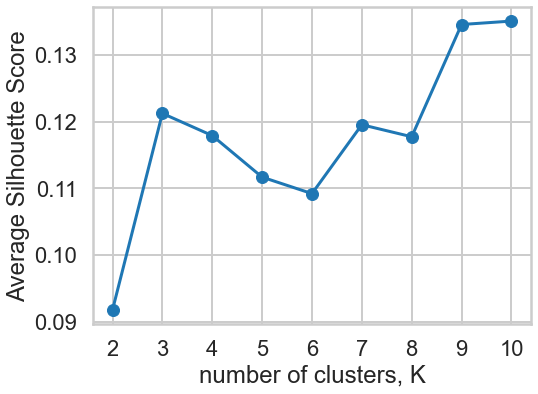

In [110]:
# Plot Ks vs SS
plt.figure(figsize=(8, 6))
plt.plot(ks, avg_silhouette_score, '-o')
plt.xlabel('number of clusters, K')
plt.ylabel('Average Silhouette Score')
plt.xticks(ks)
plt.tight_layout()

The plot of mean silhouette scores suggests that 3 clusters is the optimal choice (same as from the elbow plot).

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [74]:
#your turn
# Import PCA
from sklearn.decomposition import PCA
# Create a PCA model with 2 components: pca
pca = PCA(n_components=2,random_state=42)
#fit pca model on clustering data
pca.fit(x_cols)
#get components
pca_components = pca.transform(x_cols)

In [75]:
#variance explained by PCA components
pca.explained_variance_ratio_

array([0.14386393, 0.10800289])

The first 2 components explain about 25% of the variance.

In [18]:
#create data frame
df_pca = pd.DataFrame({"customer":df_pivot.index,"cluster":clusters.cluster,
                       "x":pca_components[:,0], "y":pca_components[:,1]})
df_pca.head()

,customer,cluster,x,y
0,Adams,3,1.007580,0.108215
1,Allen,2,-0.287539,0.044715
2,Anderson,1,-0.392032,1.038391
3,Bailey,3,0.699477,-0.022542
4,Baker,2,0.088183,-0.471695


In [22]:
df_pca.cluster= df_pca.cluster.astype('str')

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it x and then called the other y. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

C:\Users\bwitt\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='x', ylabel='y'>

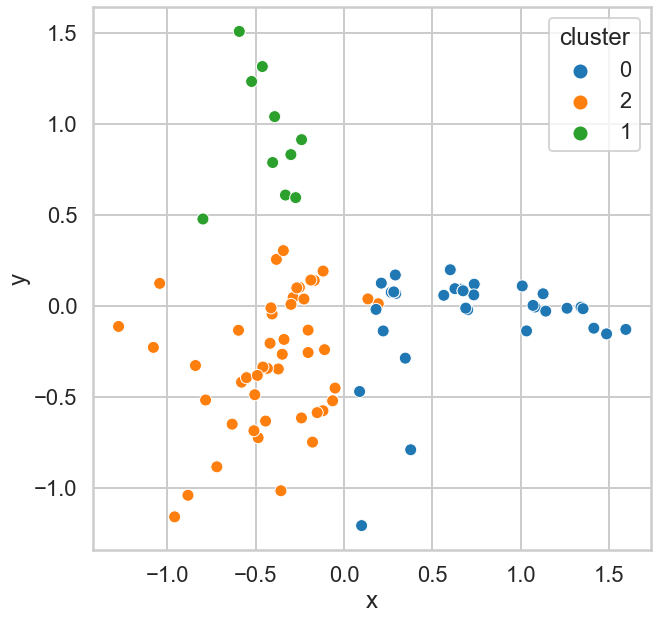

In [24]:
# Create a KMeans instance with K=3 clusters
model_3 = KMeans(n_clusters=3,random_state=42)
# Fit model to samples
model_3.fit(x_cols)
clusters_3 = pd.DataFrame({"cluster":model_3.labels_})
#new dataframe with 3 clusters
df_pca_3 = pd.DataFrame({"customer":df_pivot.index,"cluster":clusters_3.cluster,
                       "x":pca_components[:,0], "y":pca_components[:,1]})
df_pca_3.cluster= df_pca_3.cluster.astype('str')
#plot
plt.figure(figsize=(10, 10))
sns.scatterplot('x','y',hue='cluster',data=df_pca_3)

Based on K=3, the clusters look reasonably discrete. The clearest deliniation between two clusters are the orange and green points in the second and third quadrants, respectively. For the blue and orange clusters, in the fourth and third quadrants, respectively, there is some slight overlap.

Looking back at the original data, it is clear that the clusters do not neatly correspond to either the varietal or origin since there are 9 unique types of each and only 3-4 clusters. Since the minimum quantity has only 4 distinct values, this field may explain the clustering of customers. However, it could be that some customers prefer a varietal while others perfer an origin or something else. Let's investigate!

In [93]:
#unique counts of different features in original data
len(df_offers.varietal.unique()), len(df_offers.min_qty.unique()), len(df_offers.origin.unique()),len(df_offers.past_peak.unique())

(9, 4, 9, 2)

In [99]:
#using 3 cluster model, join cluster labels to pivoted data frame
df_clust3 = clusters_3.join(df_pivot.reset_index(),how='inner')
df_clust3.head()

,cluster,customer_name,1,2,3,4,5,6,7,8,...,23,24,25,26,27,28,29,30,31,32
0,0,Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,2,Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [108]:
#calculate sum of means for each group's offer purchase
df_clust3_means = df_clust3.groupby('cluster').mean()
df_clust3_means.T.sum()

cluster
0    2.864865
1    2.687500
2    3.723404
dtype: float64

In [117]:
#join offers data to the means data frame
df_offers_clust3_means = df_offers.set_index('offer_id').join(df_clust3_means.T)
df_offers_clust3_means

,campaign,varietal,min_qty,discount,origin,past_peak,0,1,2
offer_id,,,,,,,,,
1,January,Malbec,72,56,France,False,0.000000,0.0625,0.191489
2,January,Pinot Noir,72,17,France,False,0.000000,0.3750,0.085106
3,February,Espumante,144,32,Oregon,True,0.054054,0.0000,0.085106
4,February,Champagne,72,48,France,True,0.000000,0.0000,0.255319
5,February,Cabernet Sauvignon,144,44,New Zealand,True,0.000000,0.0000,0.085106
6,March,Prosecco,144,86,Chile,False,0.054054,0.0000,0.212766
7,March,Prosecco,6,40,Australia,True,0.486486,0.0000,0.021277
8,March,Espumante,6,45,South Africa,False,0.486486,0.0000,0.042553
9,April,Chardonnay,144,57,Chile,False,0.000000,0.0000,0.212766


In [125]:
#find the top 5 offers accepted by group 0
df_offers_clust3_means.sort_values(by=[0],ascending=False).head(10)

,campaign,varietal,min_qty,discount,origin,past_peak,0,1,2
offer_id,,,,,,,,,
7,March,Prosecco,6,40,Australia,True,0.486486,0.0000,0.021277
8,March,Espumante,6,45,South Africa,False,0.486486,0.0000,0.042553
30,December,Malbec,6,54,France,False,0.432432,0.0000,0.127660
29,November,Pinot Grigio,6,87,France,False,0.432432,0.0000,0.021277
18,July,Espumante,6,50,Oregon,False,0.351351,0.0000,0.021277
13,May,Merlot,6,43,Chile,False,0.162162,0.0000,0.000000
10,April,Prosecco,72,52,California,False,0.081081,0.0625,0.063830
19,July,Champagne,12,66,Germany,False,0.081081,0.0000,0.042553
21,August,Champagne,12,50,California,False,0.054054,0.0000,0.042553


In [126]:
#find the top 5 offers accepted by group 1
df_offers_clust3_means.sort_values(by=[1],ascending=False).head(10)

,campaign,varietal,min_qty,discount,origin,past_peak,0,1,2
offer_id,,,,,,,,,
26,October,Pinot Noir,144,83,Australia,False,0.000000,0.7500,0.063830
24,September,Pinot Noir,6,34,Italy,False,0.000000,0.7500,0.000000
17,July,Pinot Noir,12,47,Germany,False,0.000000,0.4375,0.000000
2,January,Pinot Noir,72,17,France,False,0.000000,0.3750,0.085106
10,April,Prosecco,72,52,California,False,0.081081,0.0625,0.063830
27,October,Champagne,72,88,New Zealand,False,0.027027,0.0625,0.148936
23,September,Chardonnay,144,39,South Africa,False,0.000000,0.0625,0.085106
16,June,Merlot,72,88,California,False,0.000000,0.0625,0.085106
12,May,Prosecco,72,83,Australia,False,0.027027,0.0625,0.063830


In [127]:
#find the top 5 offers accepted by group 2
df_offers_clust3_means.sort_values(by=[2],ascending=False).head(10)

,campaign,varietal,min_qty,discount,origin,past_peak,0,1,2
offer_id,,,,,,,,,
22,August,Champagne,72,63,France,False,0.054054,0.0000,0.404255
31,December,Champagne,72,89,France,False,0.054054,0.0000,0.319149
11,May,Champagne,72,85,France,False,0.000000,0.0000,0.276596
4,February,Champagne,72,48,France,True,0.000000,0.0000,0.255319
6,March,Prosecco,144,86,Chile,False,0.054054,0.0000,0.212766
9,April,Chardonnay,144,57,Chile,False,0.000000,0.0000,0.212766
1,January,Malbec,72,56,France,False,0.000000,0.0625,0.191489
14,June,Merlot,72,64,Chile,False,0.000000,0.0000,0.191489
27,October,Champagne,72,88,New Zealand,False,0.027027,0.0625,0.148936


From the analysis above, it looks the first group (0) takes advantage of offers where the minimum quantity is the lowest (6). These customers do not want to buy large quantities of wine at once. The second group (1) seems to heavily prefer the varietal Pinot Noir. Finally, the last group (2) is interested in Champagne from France. 

Of course, these 3 observations do not perfectly capture each group, but by and large, it looks like the three clusters are driven by the customer's preference for different aspects of the offer. That is, one group looks for minimum quanity and the other two are selective about the varietal (either Pinot Noir or Champagne). Interestingly, discount does not seem to be a significant factor for any group.

The last group (2) also has more members accepting various offers than the first two groups. Notice that for the first two groups there is a sharp dropoff of members accepting the offer outside the preferences noted above, but not for the last group. This fact accounts for the less ambiguous deliniation between this group and the other two.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [78]:
#your turn
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)
#pca_components = pca.transform(x_cols)
pca.explained_variance_ratio_

array([0.14386393, 0.10800289, 0.07104281, 0.05866151, 0.05273181,
       0.05037351, 0.04853032, 0.04281792, 0.04086488, 0.03794334,
       0.03490044, 0.03334871, 0.03051951, 0.02548482, 0.02321341,
       0.02193338, 0.01978732, 0.01870919, 0.016607  , 0.0154309 ,
       0.01369783, 0.01273333, 0.01213607, 0.01136126, 0.01032716,
       0.00919489, 0.00810601, 0.00752468, 0.00660726, 0.00580346,
       0.0050086 , 0.00273186])

In [85]:
pca.explained_variance_ratio_[:21].sum()

0.9084654300550885

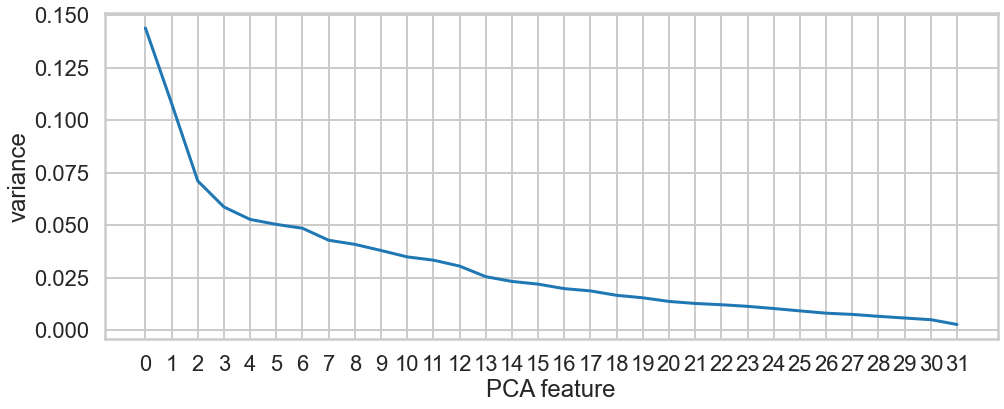

In [72]:
# Plot the explained variances
plt.figure(figsize=(16, 6))
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

From plotting the explained variance ratio, the graph suggests that 4 PCA features is the optimal number, representing the "elbow point". However, using 4 features only explains 38% of the variance. This suggests that many features are required to segment the customer accurately. In fact, 15 features are required to explain 80% of the variance and 21 for over 90% of the variance.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

------------------------------------------------
**Conclusions**

**1)** There are 3 clear groups of customers as determined by K-means clustering approach with maximizing silhouette score and visual inspection of clusters on 2 dimensional PCA plot.

**2)**  Joining the group lables to the origial data suggest that the major drivers for the customer segmentation is the minimum quantity required by the offer for one group and the wine varietal for the other two groups. Two out of the 3 groups are highly selective on these features whereas the final group has more members on average participating in a variety of offers. This leads to some ambiguous deliniation between this group and the others.

**3)**  PCA suggests that while 4 components are optimal based on the elbow plot, many features are required to acheive a high explained variance (e.g., 21/32 features for >90% explained variance).




### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [27]:
pca_x = pca_components[:,0]
pca_y = pca_components[:,1]

In [30]:
def plot_model(cluster_array):
    #define dataframe
    df = pd.DataFrame({"customer":df_pivot.index,"cluster":cluster_array.cluster,
                       "x":pca_x, "y":pca_y}) 
    #plot figure
    plt.figure(figsize=(6, 6))
    sns.scatterplot('x','y',hue='cluster',data=df)

C:\Users\bwitt\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


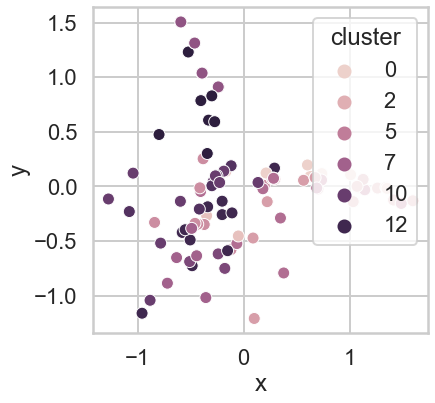

In [31]:
#Affininity Propagation
from sklearn.cluster import AffinityPropagation
af_model = AffinityPropagation(random_state=42)
af_model.fit(x_cols)
clusters_af = pd.DataFrame({"cluster":af_model.labels_})
#plots
plot_model(clusters_af)

C:\Users\bwitt\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


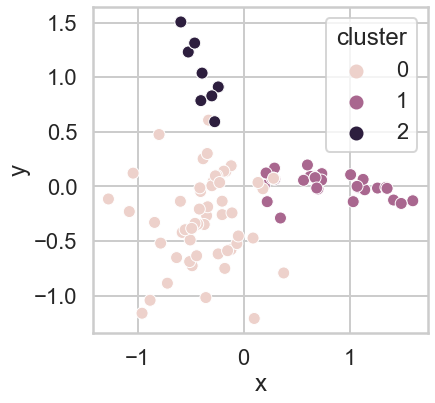

In [32]:
#Spectral Clustering
from sklearn.cluster import SpectralClustering
sc_model = SpectralClustering(n_clusters=3,random_state=42)
sc_model.fit(x_cols)
clusters_sc = pd.DataFrame({"cluster":sc_model.labels_})
#plots
plot_model(clusters_sc)

C:\Users\bwitt\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


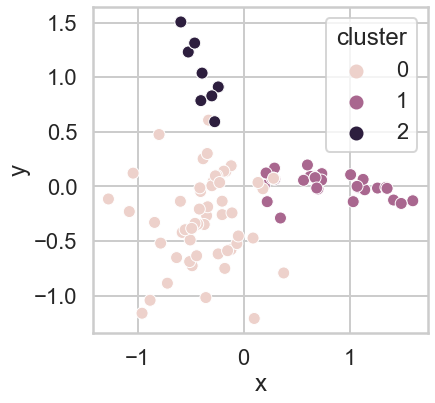

In [33]:
#Agglomerative Clustering
from sklearn.cluster import SpectralClustering
ac_model = SpectralClustering(n_clusters=3,random_state=42)
ac_model.fit(x_cols)
clusters_ac = pd.DataFrame({"cluster":ac_model.labels_})
#plots
plot_model(clusters_ac)

C:\Users\bwitt\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


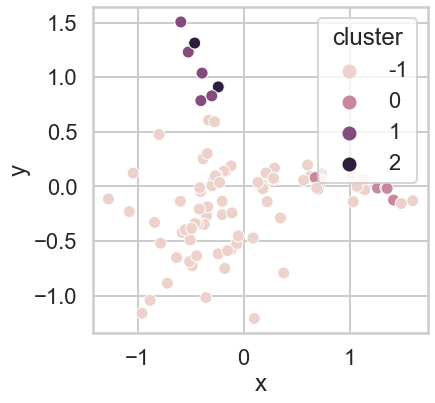

In [55]:
#DBSCAN
from sklearn.cluster import DBSCAN
DBSCAN_model = DBSCAN(eps=1,min_samples=8)
DBSCAN_model.fit(x_cols)
clusters_DBSCAN = pd.DataFrame({"cluster":DBSCAN_model.labels_})
#plots
plot_model(clusters_DBSCAN)

A cursory implementation of the four clustering algorithms suggests that spectral and agglomerative clustering (when n_clusters = 3) give clusters very similar to what is found with K-means (n_clusters = 3). With some tweaking of the epsilon and minimum samples parameters for the DBSCAN algorithm, somewhat reasonable, although somewhat poorly deliniated, clusters can be found. The affinity propagation, using the default parameters, produced 12 clusters meaning that it very probably overfit the data.

Based on the descriptions provided in tabular form above, agglomerative clustering could be best for these data since it will search non-Euclidean distances in any direction whereas spectral clustering is used for non-flat geometries. Even though, as mentioned above, both algorithms produce similar results it seems like agglomerative clustering may be more appropriate for the customer segementation data.